In [5]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys

import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms

from CNN import ConvNet1
from training_functions import *

In [2]:
batch_size = 128
num_epochs = 25

In [20]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [4]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(12872, 128, 44)
(2759, 128, 44)
(2759, 128, 44)
(12872,)
(2759,)
(2759,)


In [19]:
np.unique(y_val)

array(['2_walking', 'clutter/noise', 'running', 'vehicle', 'walking'],
      dtype='<U13')

In [21]:
# Creating the data loaders
train_loader, val_loader, test_loader = createDataloaders(x_train, y_train, x_val, y_val, x_test, y_test, batch_size)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 30 * 9, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 9)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [80]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        #self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 30 * 9, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 30 * 9)
        #x = self.dropout(x)
        x = F.relu(self.bn3(self.fc1(x)))
        #x = self.dropout(x)
        x = F.relu(self.bn4(self.fc2(x)))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x



SyntaxError: invalid syntax (<ipython-input-80-0d6c671bf222>, line 25)

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2, 1)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 16 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 16 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [24]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20,20, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(20 * 1 *8, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [3]:
# Select a model from ../Models
model_1  = Net()

In [41]:
data = iter(train_loader)
images, _ = next(data)

In [6]:
device = get_device() 
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [43]:
images = images.to(device, dtype=torch.float)
x = model_1.pool(F.relu(model_1.conv1(images)))
x = model_1.pool(F.relu(model_1.conv2(x)))
x = model_1.pool(F.relu(model_1.conv3(x)))
x.shape

torch.Size([128, 32, 16, 5])

In [11]:
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model_on_device.parameters(), lr=0.01, momentum=0.9)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['2_walking' '2_walking' '2_walking' ... 'vehicle' 'vehicle' 'vehicle'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [12]:
class_weights

tensor([0.9315, 1.0851, 1.2509, 1.1197, 0.9196, 0.8163], device='cuda:0')

In [12]:
model_on_device

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=8640, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)

In [25]:
train_model(100, train_loader, val_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/100 	 Training Loss: 1.4247, Accuracy: 16.31, Testing Loss: 1.7770, Accuracy: 27.69
Epoch: 2/100 	 Training Loss: 1.4234, Accuracy: 17.69, Testing Loss: 1.7850, Accuracy: 29.03
Epoch: 3/100 	 Training Loss: 1.4139, Accuracy: 21.64, Testing Loss: 1.7379, Accuracy: 41.57
Epoch: 4/100 	 Training Loss: 1.2478, Accuracy: 32.29, Testing Loss: 1.5031, Accuracy: 45.85
Epoch: 5/100 	 Training Loss: 1.0231, Accuracy: 44.79, Testing Loss: 1.6952, Accuracy: 46.57
Epoch: 6/100 	 Training Loss: 0.8405, Accuracy: 55.23, Testing Loss: 1.6182, Accuracy: 53.72
Epoch: 7/100 	 Training Loss: 0.9825, Accuracy: 48.38, Testing Loss: 1.4522, Accuracy: 58.10
Epoch: 8/100 	 Training Loss: 0.8218, Accuracy: 57.36, Testing Loss: 1.8513, Accuracy: 54.11
Epoch: 9/100 	 Training Loss: 0.6780, Accuracy: 63.44, Testing Loss: 1.7603, Accuracy: 61.98
Epoch: 10/100 	 Training Loss: 0.6053, Accuracy: 67.36, Testing Loss: 1.8941, Accuracy: 62.52
Epoch: 11/100 	 Training Loss: 0.6015, Accuracy: 67.96, Testing Loss:

In [13]:
torch.save(model_on_device, "model_cnn.pth")

In [14]:
dummy_input = torch.randn(128, 1, 128, 44, device='cuda')
torch.onnx.export(model_on_device, dummy_input, "model_cnn.onnx")

In [13]:
model_on_device = torch.load("model_cnn.pth")

In [23]:
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])
# Create the datasets
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

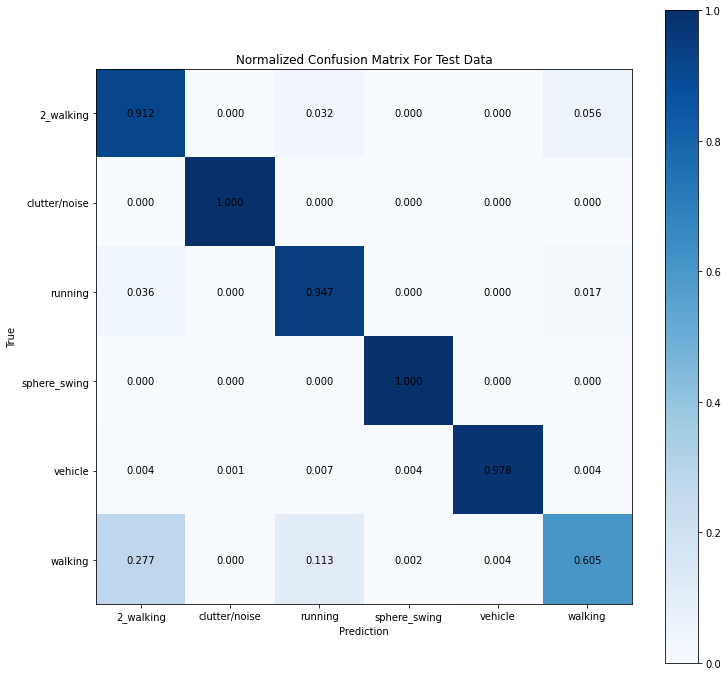

90.3003981179877

In [26]:
# Evaluate model performance on test data
#from training_functions import *
_, accuracy,errors,  y_pred_errors, y_true_errors = evaluate_model(test_loader, device, model_on_device, criterion, test_dataset, 'Test')
accuracy

In [35]:
x_test_errors = x_test[errors]
display_errors([1, 2, 3, 4, 5, 6], x_test_errors, y_pred_errors, y_true_errors, test_dataset)

IndexError: list index out of range

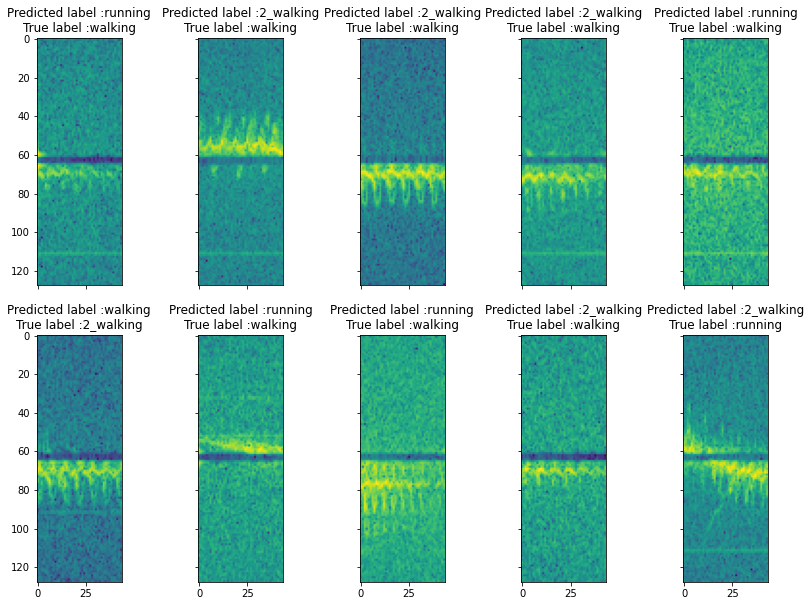

In [78]:
x_test_errors = x_test[errors]
display_errors(x_test_errors, y_pred_errors, y_true_errors, test_dataset)

In [49]:
test_dataset

In [76]:
import random
randomlist = random.sample(range(10, 30), 5)
def display_errors(img_errors, pred_errors, obs_errors, dataset):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    errors_index = random.sample(range(0, len(img_errors)), nrows*ncols)
    classes = dataset.enc.classes_.tolist()
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(14,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((128,44)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format( classes[int(pred_errors[error])], classes[int(obs_errors[error])]  ))
            n += 1

In [45]:
classes = va_dataset.enc.classes_.tolist()
classes

['2_walking', 'clutter/noise', 'running', 'sphere_swing', 'vehicle', 'walking']

In [59]:
# Adapted from https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6


In [26]:
def evaluate_model(loader, device, model_on_device, criterion, *args):

    """Evaluate Performance on test set"""
    model_on_device.eval() # Turn off gradient computations
    num_batches = len(loader)
    correct = 0
    total = 0
    running_loss = 0
    y_tot=torch.empty(0)
    y_pred_tot=torch.empty(0)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = model_on_device(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()


            labels=labels.cpu()
            predicted=predicted.cpu()

            y_tot = torch.cat((y_tot, labels), 0)
            y_pred_tot = torch.cat((y_pred_tot, predicted), 0)

    accuracy = 100 * correct / total       
    errors = (y_pred_tot - y_tot  != 0)
    y_pred_errors = y_pred_tot[errors]
    y_true_errors = y_tot[errors]

    # Plotting the Confusion Matrix
    assert len(args)==2 or len(args)==0, 'Please insert both dataset and dataset name'
    if args:
        cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy())
        np.set_printoptions(precision=4)

        # Coloured confusion matrix
        plt.figure(figsize = (12,12))
        cm = confusion_matrix(y_tot.numpy(), y_pred_tot.numpy(), normalize="true")
        plt.imshow(cm, cmap=plt.cm.Blues)

        for (i, j), z in np.ndenumerate(cm):
            plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
        
        plt.xticks(range(6))
        plt.yticks(range(6))
        plt.xlabel("Prediction")
        plt.ylabel("True")

        # We can retrieve the categories used by the LabelEncoder
        classes = args[0].enc.classes_.tolist()
        plt.gca().set_xticklabels(classes)
        plt.gca().set_yticklabels(classes)

        plt.title("Normalized Confusion Matrix For "+ args[1] + " Data")
        plt.colorbar()
        plt.show()
    return running_loss / num_batches, accuracy, errors, y_pred_errors, y_true_errors 

In [15]:
model_on_device.eval()
Y_pred = model_on_device.predict(x_val)

ModuleAttributeError: 'Net' object has no attribute 'predict'

In [15]:

Confusion_Matrix(model_on_device, train_loader, train_dataset, 'train')

NameError: name 'Confusion_Matrix' is not defined

In [28]:
# Save the model
torch.save(model_on_device, "model.pth")

## Training using the cross validation approach

### Adapted from https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

In [9]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from pytorchtools import EarlyStopping
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [10]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data_cv.npz"
processed_data = np.load(compressed_file_path) # Unzipping
x_train_cv = processed_data["x_train"]
y_train_cv = processed_data["y_train"]

x_test_cv = processed_data["x_test"]
y_test_cv = processed_data["y_test"]

In [15]:
# Configuration options
device = get_device() 
k_folds = 10
num_epochs = 100


class_weights = get_class_weights(y_train_cv, device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)


# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Prepare MNIST dataset by concatenating Train/Test part; we split later.
""""
dataset_train_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
dataset_test_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)
dataset = ConcatDataset([dataset_train_part, dataset_test_part])
"""
transform = transforms.Compose(
[
transforms.ToTensor()
])
# Create the datasets
dataset_train_part = HAVSDataset(x_train_cv, y_train_cv, transform=transform)
dataset_test_part = HAVSDataset(x_test_cv, y_test_cv, transform=transform)
dataset = dataset_train_part

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=False)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, y_train_cv)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=10, sampler=test_subsampler)

    # Init the neural network
    network = Net()
    network_on_device = network.to(device) # Move model to the current device
    network_on_device.apply(reset_weights)


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network_on_device.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
        
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
  
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = network_on_device(inputs)
            
            # Compute loss
            loss = loss_function(outputs, targets)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                        (i + 1, current_loss / 500))
                current_loss = 0.0

        # Check early stopping
        test_loss, _, _, _, _ = evaluate_model(testloader, device, network_on_device, loss_function)
        early_stopping(test_loss, network_on_device)
        if early_stopping.early_stop:
            print("Early stopping")
            break           
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)
            # Generate outputs
            outputs = network_on_device(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

 out of 20
Starting epoch 48
Loss after mini-batch   500: 0.175
Loss after mini-batch  1000: 0.184
EarlyStopping counter: 2 out of 20
Starting epoch 49
Loss after mini-batch   500: 0.171
Loss after mini-batch  1000: 0.176
Validation loss decreased (0.301706 --> 0.283797).  Saving model ...
Starting epoch 50
Loss after mini-batch   500: 0.162
Loss after mini-batch  1000: 0.174
EarlyStopping counter: 1 out of 20
Starting epoch 51
Loss after mini-batch   500: 0.164
Loss after mini-batch  1000: 0.161
EarlyStopping counter: 2 out of 20
Starting epoch 52
Loss after mini-batch   500: 0.153
Loss after mini-batch  1000: 0.159
EarlyStopping counter: 3 out of 20
Starting epoch 53
Loss after mini-batch   500: 0.155
Loss after mini-batch  1000: 0.136
EarlyStopping counter: 4 out of 20
Starting epoch 54
Loss after mini-batch   500: 0.138
Loss after mini-batch  1000: 0.150
EarlyStopping counter: 5 out of 20
Starting epoch 55
Loss after mini-batch   500: 0.129
Loss after mini-batch  1000: 0.137
EarlyS

KeyboardInterrupt: 

In [28]:
 test_loader = DataLoader(dataset=dataset_test_part, batch_size=batch_size, shuffle=False)

In [43]:
model = Net()
model.load_state_dict(torch.load('model-fold-2.pth'))
model_0_on_device = model.to(device) 

In [ ]:
# Training the model on the whole dataset
train_model(100, train_loader, val_loader, criterion, optimizer, device, model_on_device)

In [44]:
evaluate_model(test_loader, device, model_0_on_device, loss_function)

(0.42937398340466737, 86.14883215643673)